In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics, model_selection
import glob
import os
from PIL import Image
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50 as Engine

from albumentations import *

gpus = tf.config.experimental.list_physical_devices('GPU')
num_gpus = len(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(num_gpus, "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


In [2]:
input_path = '../input/siim-isic-melanoma-classification/'
train_data = pd.read_csv(input_path + 'train.csv')
test_data = pd.read_csv(input_path + 'test.csv')
submission_data = pd.read_csv(input_path + 'sample_submission.csv')
test_data['target'] = 0
print("test shape =", test_data.shape)
print(test_data.head(3))
print("\ntrain shape =", train_data.shape)
print(train_data.head(3))

test shape = (10982, 6)
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0052060  IP_3579794    male        70.0                           NaN   
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity   
2  ISIC_0058510  IP_7960270  female        55.0                         torso   

   target  
0       0  
1       0  
2       0  

train shape = (33126, 8)
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  


In [3]:
augmentor = (
    Compose([
        OneOf([
            ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=90,
                p=0.5),
            ElasticTransform(
                alpha=601,
                sigma=20,
                alpha_affine=10,
                p=0.5),
            GridDistortion(
                num_steps=3,
                distort_limit=0.5,
                p=0.5),
            NoOp()
        ]),
        OneOf([
            RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.5),
            RandomGamma(
                gamma_limit=(85, 115),
                p=0.5),
            NoOp()
        ]),
        OneOf([
            RGBShift(
                r_shift_limit=(-15, 15),
                g_shift_limit=(-15, 15),
                b_shift_limit=(-15, 15),
                p=0.5),
            HueSaturationValue(
                hue_shift_limit=(-15, 15),
                sat_shift_limit=(-25, 25),
                val_shift_limit=(-15, 15),
                p=0.5),
            NoOp()
        ]),
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)


def tf_map_decorator(func):
    """Decorate python functions with this 
    decorator: Enables arbitrary python 
    code to work in the TF graph
    """
    def wrapper(*args):
        return tf.py_function(
            func=func,
            inp=[*args],
            Tout=[a.dtype for a in args]
        )
    return wrapper

@tf_map_decorator
def _apply_augmentation(image, target):
    """Using albumentations augmentations wrapped in
    tf.py_functions is very convenient. However, for 
    better performance, consider using TF operations 
    instead to augment the image data
    """
    image = augmentor(image=image.numpy())['image']
    return image, target

def _read_input(path, target, target_size):
    """Reads, decodes and resizes the image.
    'target' is also passed to the function for 
    convenience (to work well with dataset.map(..))
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, *target_size[:-1], method='bilinear')
    image = tf.cast(image, dtype=tf.uint8)
    return image, target

def _preprocess_input(image, target):
    """Simple preprocessing of the input,
    before being fed to the neural network
    """
    image = tf.cast(image, tf.float32)
    target = tf.cast(target, tf.float32)
    image /= 255.
    return image, target

def create_dataset(path, 
                   dataframe, 
                   input_shape,
                   batch_size,
                   augment=False,
                   shuffle=False,
                   cache=False,):
    
    if cache:
        if not(os.path.isdir('tmp/')):
            os.mkdir('tmp/')
        else:
            files = glob.glob('tmp/*')
            for file in files:
                os.remove(file)
        
        cache_path = 'tmp/' + path.split('/')[-1]
    
    if shuffle:
        dataframe = dataframe.sample(frac=1.0, replace=False)
    
    image_paths = path + dataframe.image_name + '.jpg'
    targets = np.expand_dims(dataframe.target, -1)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, targets))
    
    dataset = dataset.map(
        lambda x, y: (
            _read_input(x, y, target_size=input_shape)
        ), tf.data.experimental.AUTOTUNE)
    
    if cache:
        dataset = dataset.cache(cache_path)
    
    if augment:
        dataset = dataset.map(_apply_augmentation, tf.data.experimental.AUTOTUNE)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(_preprocess_input, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset


In [4]:
class NeuralNet(tf.keras.Model):

    def __init__(self, engine, input_shape, units,
                 dropout, activation, weights=None):

        super(NeuralNet, self).__init__()

        self.engine = engine(
            include_top=False,
            input_shape=input_shape,
            weights=weights)

        self.pool = tf.keras.layers.GlobalAveragePooling2D()

        self.head = tf.keras.Sequential()
        for drop, unit, actv in zip(dropout, units, activation):
            self.head.add(tf.keras.layers.Dropout(drop))
            self.head.add(tf.keras.layers.Dense(unit, actv, dtype='float32'))

    def call(self, inputs, **kwargs):
        x = self.engine(inputs)
        x = self.pool(x)
        return self.head(x)
    
    
class DistributedModel:
    
    def __init__(self, 
                 keras_model,
                 batch_size=8,
                 optimizer=None, 
                 strategy=None,
                 mixed_precision=False, 
                 label_smoothing=0.0):
        
        self.keras_model = keras_model
        self.global_batch_size = batch_size
        self.mixed_precision = mixed_precision
        self.optimizer = optimizer
        self.strategy = strategy
        self.label_smoothing = label_smoothing
        
        if self.optimizer and self.mixed_precision:
            self.optimizer = \
                tf.keras.mixed_precision.experimental.LossScaleOptimizer(
                    optimizer, loss_scale='dynamic')
                
        if self.strategy:
            self.global_batch_size *= self.strategy.num_replicas_in_sync
            
        if not(os.path.isdir('output/weights')):
            os.makedirs('output/weights')      
    
    
    def _compute_loss(self, labels, logits):
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=labels, logits=logits) 
        return tf.nn.compute_average_loss(
            per_example_loss, global_batch_size=self.global_batch_size)
        
        
    def _train_step(self, inputs):
        
        images, labels = inputs
        
        if self.label_smoothing:
            labels = (
                labels * (1 - self.label_smoothing)
                + 0.5 * self.label_smoothing
            )
            
        with tf.GradientTape() as tape:
            logits = self.keras_model(images, training=True)
            loss = self._compute_loss(labels, logits)
            if self.mixed_precision:
                scaled_loss = self.optimizer.get_scaled_loss(loss)
                
        if self.mixed_precision:
            scaled_gradients = tape.gradient(
                scaled_loss, self.keras_model.trainable_variables)
            gradients = self.optimizer.get_unscaled_gradients(scaled_gradients)
        else:
            gradients = tape.gradient(loss, self.keras_model.trainable_variables)
            
        self.optimizer.apply_gradients(
            zip(gradients, self.keras_model.trainable_variables))
        
        return loss
    
    
    def _predict_step(self, inputs):
        images, labels = inputs
        logits = self.keras_model(images, training=False)
        return tf.math.sigmoid(logits), labels
    
    
    def predict(self, test_ds, weights, tta, strategy):
        
        @tf.function
        def distributed_predict_step(dist_inputs):
            preds, trues = strategy.run(self._predict_step, args=(dist_inputs,))
            if tf.is_tensor(preds):
                return [preds], [trues]
            else:
                return preds.values, trues.values
        
        test_dist_ds = strategy.experimental_distribute_dataset(test_ds)
        test_dist_ds = tqdm.tqdm(test_dist_ds)
        self.keras_model.load_weights(weights)
        
        preds_accum = np.zeros([0, 1], dtype=np.float32)
        trues_accum = np.zeros([0, 1], dtype=np.float32)
        for inputs in test_dist_ds.repeat(tta):
            preds, trues = distributed_predict_step(inputs)
        
            for pred, true in zip(preds, trues):
                preds_accum = np.concatenate([preds_accum, pred.numpy()], axis=0)
                trues_accum = np.concatenate([trues_accum, true.numpy()], axis=0)
        
        preds_accum = np.array(preds_accum).reshape((tta, -1))
        trues_accum = np.array(trues_accum).reshape((tta, -1))
        
        return preds_accum, trues_accum
            
        
    def fit_and_predict(self, fold, epochs, train_ds, valid_ds, test_ds, strategy):
    
        @tf.function
        def distributed_train_step(dist_inputs):
            per_replica_loss = strategy.run(self._train_step, args=(dist_inputs,))
            return strategy.reduce(
                tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)

        @tf.function
        def distributed_predict_step(dist_inputs):
            preds, trues = strategy.run(self._predict_step, args=(dist_inputs,))
            if tf.is_tensor(preds):
                return [preds], [trues]
            else:
                return preds.values, trues.values
        
        valid_preds_accum = np.zeros([0, 1], dtype=np.float32)
        test_preds_accum = np.zeros([0, 1], dtype=np.float32)
        
        epochs_score = 0.
        last_epoch_score = 0.
        best_score = 0.
        for epoch in range(epochs):
            train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
            valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)
            test_dist_ds = strategy.experimental_distribute_dataset(test_ds)
            train_dist_ds = tqdm.tqdm(train_dist_ds)
            valid_dist_ds = tqdm.tqdm(valid_dist_ds)
            test_dist_ds = tqdm.tqdm(test_dist_ds)
            
            # TRAIN LOOP -----------------------------------
            epoch_loss = 0.
            for i, inputs in enumerate(train_dist_ds):
                loss = distributed_train_step(inputs)
                epoch_loss += loss
                train_dist_ds.set_description(
                    "Scores [{:.4f}, {:.4f}] : Loss {:.5f}"
                    .format(epochs_score, last_epoch_score, epoch_loss/(i+1)))
            
            # VALIDATION LOOP ------------------------------
            valid_trues_accum = np.zeros([0, 1], dtype=np.float32)
            for inputs in valid_dist_ds:
                preds, trues = distributed_predict_step(inputs)
                for pred, true in zip(preds, trues):
                    valid_preds_accum = np.concatenate(
                        [valid_preds_accum, pred.numpy()], axis=0)
                    valid_trues_accum = np.concatenate(
                        [valid_trues_accum, true.numpy()], axis=0)
                    
            last_epoch_score = metrics.roc_auc_score(
                valid_trues_accum, valid_preds_accum.reshape((epoch+1, -1))[-1])
            if last_epoch_score > best_score:
                best_score = last_epoch_score
                self.keras_model.save_weights(f'output/weights/model-{fold}-{epoch}.h5')
            epochs_score = metrics.roc_auc_score(
                valid_trues_accum, np.average(
                    valid_preds_accum.reshape((epoch+1, -1)), 
                    axis=0, weights=[2**i for i in range(epoch+1)]))
            
            # TEST LOOP ------------------------------------
            for inputs in test_dist_ds:
                preds, trues = distributed_predict_step(inputs)
                for pred, _ in zip(preds, trues):
                    test_preds_accum = np.concatenate(
                        [test_preds_accum, pred.numpy()], axis=0)
                    
        return valid_preds_accum, test_preds_accum

In [ ]:
fold = 0
epochs = 10
batch_size = 16
learning_rate = 3e-4
input_shape=(384, 384, 3)
units = [1]
dropout = [0.2]
activation = [None]
label_smoothing = 0.0
weights = "imagenet"


gss = model_selection.GroupShuffleSplit(n_splits=5, random_state=42)
gss_iterator = gss.split(
    X=train_data.index, 
    y=train_data.target,
    groups=train_data.patient_id
)
for _ in range(fold+1): 
    train_idx, valid_idx = next(gss_iterator)
    

train_ds = create_dataset(
    path=input_path+'jpeg/train/', 
    dataframe=train_data.iloc[train_idx],
    input_shape=input_shape,
    batch_size=batch_size,
    augment=True,
    shuffle=True,
    cache=False,)

valid_ds = create_dataset(
    path=input_path+'jpeg/train/', 
    dataframe=train_data.iloc[valid_idx], 
    input_shape=input_shape,
    batch_size=batch_size,
    augment=False,
    shuffle=False,
    cache=False,)

test_ds = create_dataset(
    path=input_path+'jpeg/test/', 
    dataframe=test_data, 
    input_shape=input_shape,
    batch_size=batch_size,
    augment=False,
    shuffle=False,
    cache=False,)

strategy = tf.distribute.OneDeviceStrategy(device='GPU')

with strategy.scope():
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    model = NeuralNet(
        engine=Engine,
        input_shape=input_shape,
        units=units,
        dropout=dropout,
        activation=activation,
        weights=weights)
    
    model.build([None, *input_shape])
    
    dist_model = DistributedModel(
        keras_model=model,
        batch_size=batch_size,
        optimizer=optimizer, 
        strategy=strategy,
        mixed_precision=True, 
        label_smoothing=label_smoothing)

    valid_preds, test_preds = dist_model.fit_and_predict(
        fold=fold, 
        epochs=epochs, 
        train_ds=train_ds, 
        valid_ds=valid_ds, 
        test_ds=test_ds, 
        strategy=strategy
    )
    
    
submission_data.to_csv('submission.csv', index=False)

In [28]:
valid_preds

array([[0.00757897],
       [0.00747694],
       [0.0079152 ],
       ...,
       [0.00238677],
       [0.00852828],
       [0.00882777]], dtype=float32)

In [7]:
metrics.roc_auc_score(train_data.iloc[valid_idx].target, valid_preds.reshape((2, -1))[-1])

0.8573937215145562

(array([5.898e+03, 6.190e+02, 1.900e+02, 8.800e+01, 4.500e+01, 2.900e+01,
        2.200e+01, 1.400e+01, 1.300e+01, 9.000e+00, 6.000e+00, 4.000e+00,
        3.000e+00, 7.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([5.60798107e-28, 1.19795026e-02, 2.39590053e-02, 3.59385088e-02,
        4.79180105e-02, 5.98975122e-02, 7.18770176e-02, 8.38565156e-02,
        9.58360210e-02, 1.07815519e-01, 1.19795024e-01, 1.31774530e-01,
        1.43754035e-01, 1.55733526e-01, 1.67713031e-01, 1.79692537e-01,
        1.91672042e-01, 2.03651547e-01, 2.15631038e-01, 2.27610543e-01,
        2.395900

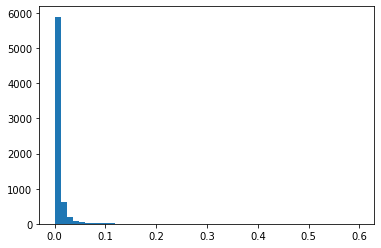

In [34]:
plt.hist(valid_preds.reshape((2, -1))[-2], bins=50)

(array([8.430e+03, 1.685e+03, 3.680e+02, 1.420e+02, 8.700e+01, 4.600e+01,
        4.000e+01, 2.900e+01, 2.700e+01, 2.400e+01, 1.700e+01, 1.500e+01,
        1.400e+01, 1.100e+01, 5.000e+00, 0.000e+00, 5.000e+00, 2.000e+00,
        5.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00]),
 array([7.06491270e-27, 9.69844311e-03, 1.93968862e-02, 2.90953293e-02,
        3.87937725e-02, 4.84922156e-02, 5.81906587e-02, 6.78891018e-02,
        7.75875449e-02, 8.72859880e-02, 9.69844311e-02, 1.06682874e-01,
        1.16381317e-01, 1.26079753e-01, 1.35778204e-01, 1.45476639e-01,
        1.55175090e-01, 1.64873526e-01, 1.74571976e-01, 1.84270412e-01,
        1.939688

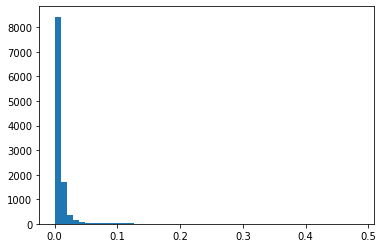

In [35]:
plt.hist(test_preds.reshape((2, -1))[-2], bins=50)